In [30]:
import tensorflow as tf
import tf_keras as keras
import random
import shutil
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys,make_confusion_matrix

In [3]:
import tensorflow_datasets as tfds

In [4]:
datasets_list = tfds.list_builders()
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


In [10]:
(train_data, test_data), ds_info = tfds.load(name = "food101",
                                             split = ["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

c:\Users\ali-k\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:   0%|          | 0/1 [01:54<?, ? url/s]


In [9]:
import tarfile

tar_path = r"C:\Users\ali-k\OneDrive\Documents\Machine Learning\TensorFlow for Deep Learning\food-101.tar.gz"
extract_path = r"C:\Users\ali-k\OneDrive\Documents\Machine Learning\TensorFlow for Deep Learning\food-101"

with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)
    
test_file_path  = r"C:\Users\ali-k\OneDrive\Documents\Machine Learning\TensorFlow for Deep Learning\food-101\food-101\meta\test.txt"
with open(test_file_path, 'r') as file:
    test_images = file.read().splitlines()
    
base_dir = r"C:\Users\ali-k\OneDrive\Documents\Machine Learning\TensorFlow for Deep Learning\food-101\food-101"
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

for line in test_images:
    class_name = line.split('/')[0]
    class_dir = os.path.join(test_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

original_dataset_dir = r"C:\Users\ali-k\OneDrive\Documents\Machine Learning\TensorFlow for Deep Learning\food-101\food-101\images"

for image_path in test_images:
    class_name, image_name = image_path.split('/')
    src = os.path.join(original_dataset_dir, image_path + '.jpg')
    dst = os.path.join(test_dir, class_name, image_name + '.jpg')
    shutil.move(src, dst)
    
target_dir = r'C:\Users\ali-k\OneDrive\Documents\Machine Learning\TensorFlow for Deep Learning\food-101\food-101\train'
os.makedirs(target_dir, exist_ok=True)

for item_name in os.listdir(original_dataset_dir):
    item_path = os.path.join(original_dataset_dir, item_name)
    
    if os.path.isdir(item_path):
        dest_path = os.path.join(target_dir, item_name)
        
        shutil.move(item_path, dest_path)

if os.listdir(original_dataset_dir) == []:
    os.rmdir(original_dataset_dir)
    print(f"Deleted empty directory: {original_dataset_dir}")
else:
    print(f"Directory is not empty: {original_dataset_dir}")


In [67]:
train_dir = r'C:\Users\ali-k\OneDrive\Documents\Machine Learning\TensorFlow for Deep Learning\food-101\food-101\train'
test_dir = r'C:\Users\ali-k\OneDrive\Documents\Machine Learning\TensorFlow for Deep Learning\food-101\food-101\test'

train_data = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),  
    batch_size=32,          
    shuffle=True
)

test_data = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),  
    batch_size=32,          
    shuffle=False
)

Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [49]:
class_names = train_data.class_names

In [79]:
train_one_sample = train_data.take(1) 

for image, label in train_one_sample:
    for i in range(3):
        print(f"""
        Image shape: {image[i].shape}
        Image dtype: {image[i].dtype}
        Target class from Food101 (tensor form): {label[i].numpy()}
        Class name (str form): {class_names[label[i].numpy()]}
        """)



        Image shape: (224, 224, 3)
        Image dtype: <dtype: 'float32'>
        Target class from Food101 (tensor form): 62
        Class name (str form): macaroni_and_cheese
        

        Image shape: (224, 224, 3)
        Image dtype: <dtype: 'float32'>
        Target class from Food101 (tensor form): 83
        Class name (str form): red_velvet_cake
        

        Image shape: (224, 224, 3)
        Image dtype: <dtype: 'float32'>
        Target class from Food101 (tensor form): 51
        Class name (str form): guacamole
        


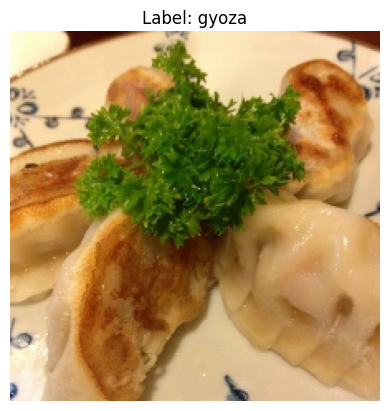

In [88]:
train_one_sample = train_data.take(1)

train_one_sample_iter = train_one_sample.as_numpy_iterator()

image_batch, label_batch = next(train_one_sample_iter)

index = random.randint(0, 32)

image = image_batch[index]
label = label_batch[index]
plt.imshow(image/255)
plt.title(f"Label: {class_names[label]}")
plt.axis(False) 
plt.show()

In [89]:
checkpoint_path = "model_checkpoints/cp.ckpt"

model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                   monitor = "val_accuracy",
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   verbose=0)

In [95]:
input_shape = (224,224,3)
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = keras.layers.Input(shape=input_shape,name = "input_layer")

x = base_model(inputs,training=False)
x = keras.layers.GlobalAveragePooling2D(name = "pooling_layer")(x)
x = keras.layers.Dense(len(class_names))(x)

outputs = keras.layers.Activation("softmax", dtype=tf.float32,name = "softmax_float32")(x)
model = keras.Model(inputs,outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [96]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [105]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240905-192653
Epoch 1/3
2368/2368 [==============================] - 2035s 840ms/step - loss: 1.7178 - accuracy: 0.5825 - val_loss: 1.2972 - val_accuracy: 0.6462
Epoch 2/3
2368/2368 [==============================] - 2515s 1s/step - loss: 1.1997 - accuracy: 0.6890 - val_loss: 1.1996 - val_accuracy: 0.6706
Epoch 3/3
2368/2368 [==============================] - 2091s 883ms/step - loss: 1.0543 - accuracy: 0.7251 - val_loss: 1.1489 - val_accuracy: 0.6838


In [107]:
# save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
# model.save(save_dir)

In [108]:
# loaded_saved_model = keras.models.load_model(save_dir)

In [16]:
for layer in model.layers:
    model.trainable = True
    print(layer.name,layer.trainable)

input_layer True
efficientnetb0 True
pooling_layer True
dense_2 True
softmax_float32 True


In [17]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss",
                                               patience=3)

checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                   monitor="val_loss",
                                                   save_best_only=True)


In [18]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

In [22]:
model.compile(loss = "sparse_categorical_crossentropy",
                           optimizer = keras.optimizers.Adam(1e-4),
                           metrics = ["accuracy"])

In [20]:
model.fit(train_data,
            epochs=100,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.15 * len(test_data)), 
            callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), 
                        model_checkpoint,
                        early_stopping, 
                        reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20240906-211127
Epoch 1/100



  11/2368 [..............................] - ETA: 7:29:14 - loss: 0.9616 - accuracy: 0.7784

KeyboardInterrupt: 

In [24]:
model.evaluate(test_data)

790/790 [==============================] - 788s 986ms/step - loss: 1.0033 - accuracy: 0.7272


[1.003273844718933, 0.7272475361824036]

In [36]:
preds_prob = model.predict(test_data,verbose=1)

790/790 [==============================] - 662s 821ms/step


In [47]:
pred_classes = preds_prob.argmax(axis=1)
pred_classes[:10]

array([52,  0, 97,  0,  0, 78, 29,  0,  2, 41], dtype=int64)

In [72]:
y_labels = []

for images, labels in test_data:
    y_labels.extend(labels.numpy())

In [71]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [73]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.53      0.46      0.50       250
           1       0.82      0.68      0.74       250
           2       0.76      0.79      0.77       250
           3       0.69      0.80      0.74       250
           4       0.55      0.63      0.59       250
           5       0.51      0.67      0.58       250
           6       0.73      0.85      0.78       250
           7       0.83      0.89      0.86       250
           8       0.61      0.41      0.49       250
           9       0.72      0.60      0.66       250
          10       0.78      0.49      0.60       250
          11       0.62      0.83      0.71       250
          12       0.70      0.80      0.75       250
          13       0.74      0.68      0.71       250
          14       0.79      0.69      0.74       250
          15       0.60      0.55      0.58       250
          16       0.74      0.69      0.71       250
          17       0.61    

In [74]:
report = classification_report(y_labels, pred_classes,output_dict=True)
report

{'0': {'precision': 0.5321100917431193,
  'recall': 0.464,
  'f1-score': 0.49572649572649574,
  'support': 250.0},
 '1': {'precision': 0.824390243902439,
  'recall': 0.676,
  'f1-score': 0.7428571428571429,
  'support': 250.0},
 '2': {'precision': 0.7576923076923077,
  'recall': 0.788,
  'f1-score': 0.7725490196078432,
  'support': 250.0},
 '3': {'precision': 0.6872852233676976,
  'recall': 0.8,
  'f1-score': 0.7393715341959335,
  'support': 250.0},
 '4': {'precision': 0.548951048951049,
  'recall': 0.628,
  'f1-score': 0.585820895522388,
  'support': 250.0},
 '5': {'precision': 0.5138461538461538,
  'recall': 0.668,
  'f1-score': 0.5808695652173913,
  'support': 250.0},
 '6': {'precision': 0.726962457337884,
  'recall': 0.852,
  'f1-score': 0.7845303867403315,
  'support': 250.0},
 '7': {'precision': 0.8283582089552238,
  'recall': 0.888,
  'f1-score': 0.8571428571428571,
  'support': 250.0},
 '8': {'precision': 0.6058823529411764,
  'recall': 0.412,
  'f1-score': 0.49047619047619045,

In [75]:
class_f1_scores = {}
for k,v in report.items():
    if k == "accuracy":
        break
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.49572649572649574,
 'baby_back_ribs': 0.7428571428571429,
 'baklava': 0.7725490196078432,
 'beef_carpaccio': 0.7393715341959335,
 'beef_tartare': 0.585820895522388,
 'beet_salad': 0.5808695652173913,
 'beignets': 0.7845303867403315,
 'bibimbap': 0.8571428571428571,
 'bread_pudding': 0.49047619047619045,
 'breakfast_burrito': 0.6550976138828634,
 'bruschetta': 0.5995085995085995,
 'caesar_salad': 0.7135506003430532,
 'cannoli': 0.75,
 'caprese_salad': 0.7068607068607069,
 'carrot_cake': 0.7377398720682303,
 'ceviche': 0.5762004175365344,
 'cheese_plate': 0.7107438016528925,
 'cheesecake': 0.5603448275862069,
 'chicken_curry': 0.6310904872389791,
 'chicken_quesadilla': 0.7628458498023716,
 'chicken_wings': 0.8095238095238095,
 'chocolate_cake': 0.6666666666666666,
 'chocolate_mousse': 0.5364806866952789,
 'churros': 0.8336933045356372,
 'clam_chowder': 0.823076923076923,
 'club_sandwich': 0.7802197802197802,
 'crab_cakes': 0.5758928571428571,
 'creme_brulee': 0.8470588235

In [76]:
import pandas as pd

f1_scores = pd.DataFrame({"class_name":list(class_f1_scores.keys()),
                          "f1-score":list(class_f1_scores.values())}).sort_values("f1-score", ascending=True)
f1_scores.head()

,class_name,f1-score
93,steak,0.447489
82,ravioli,0.453608
77,pork_chop,0.489540
8,bread_pudding,0.490476
0,apple_pie,0.495726


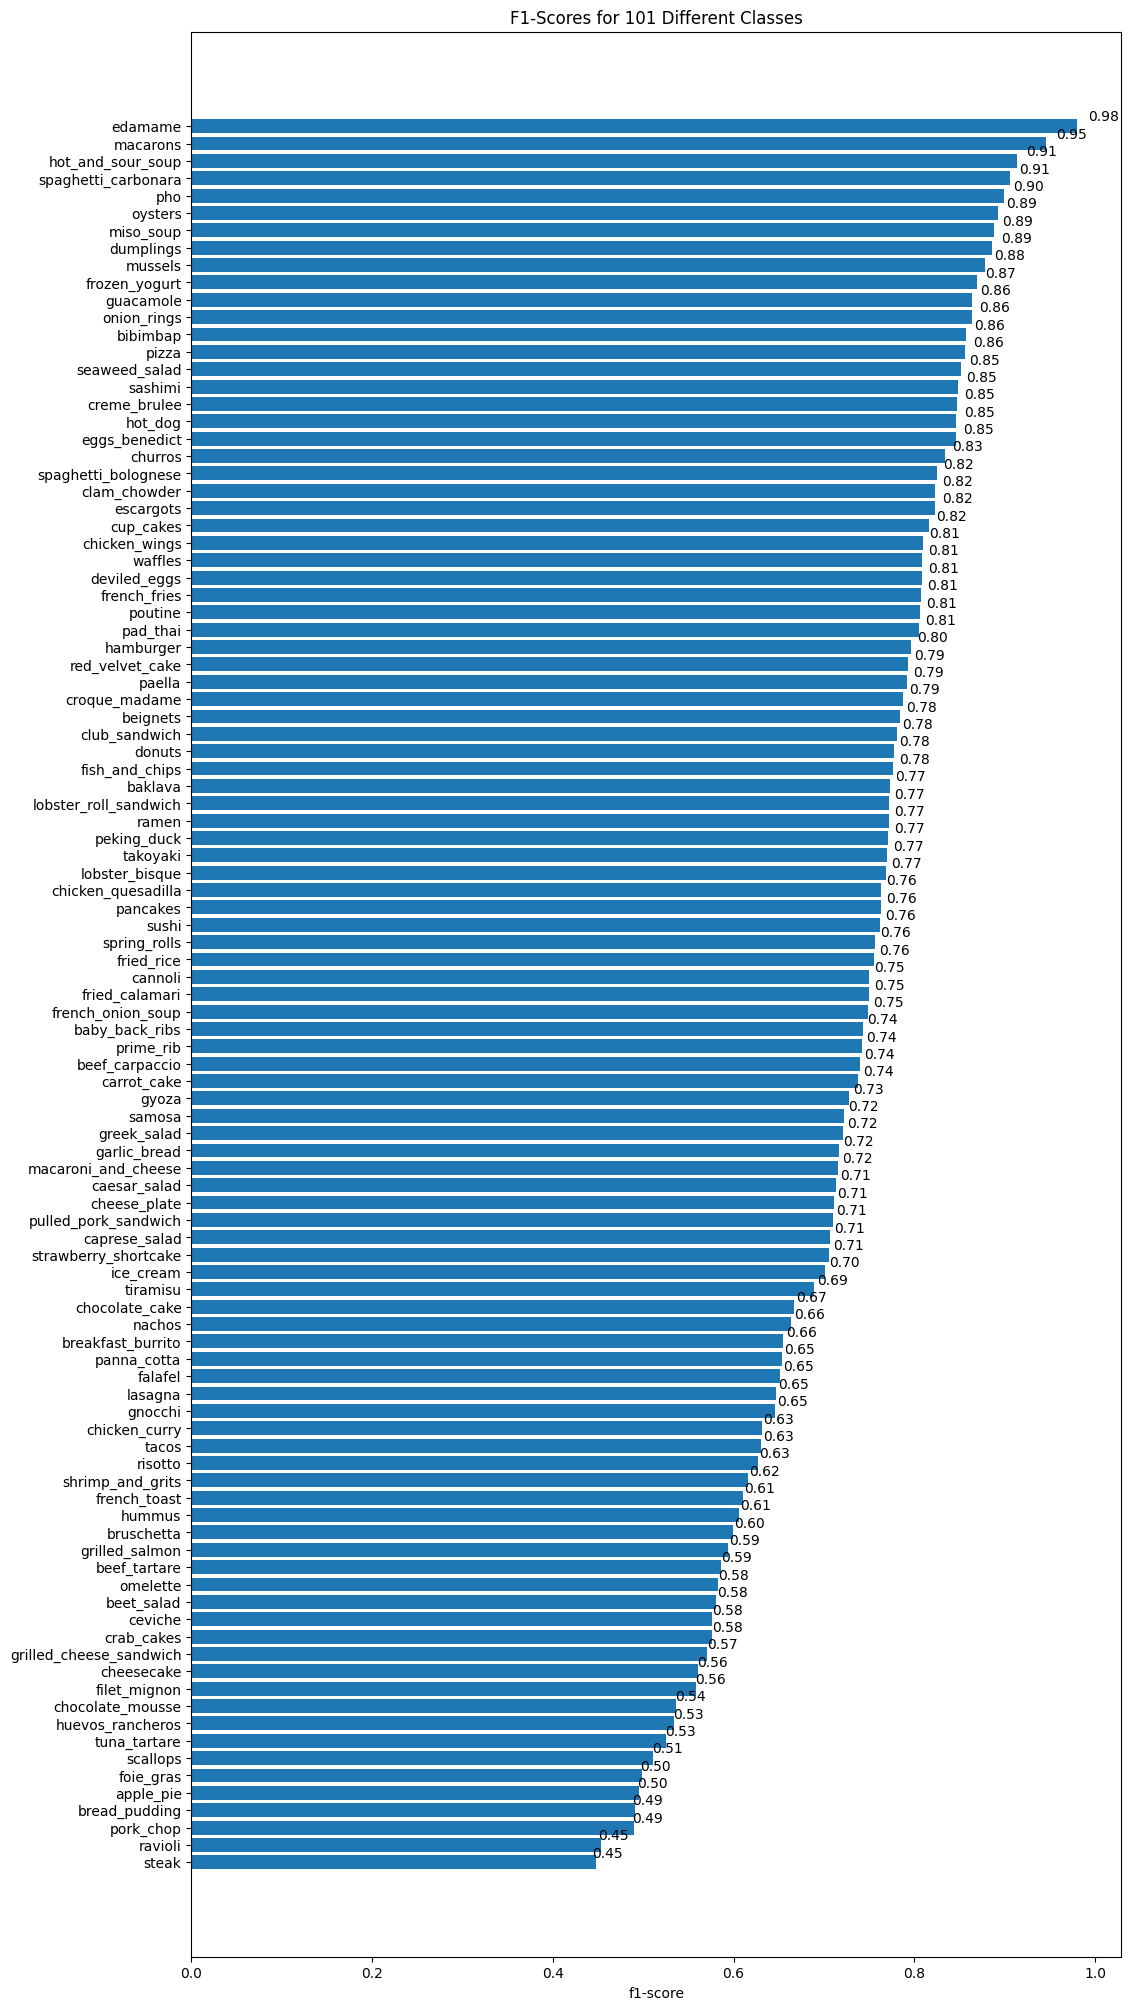

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

1/1 [==============================] - 0s 49ms/step


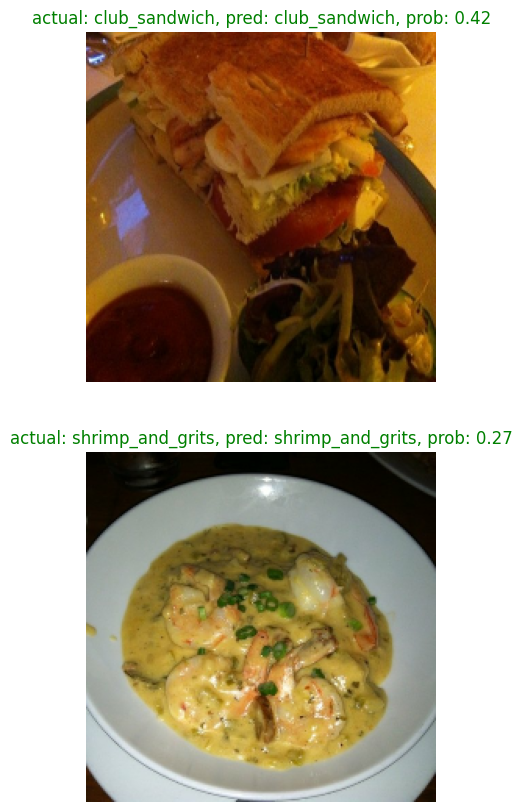

In [95]:
plt.figure(figsize=(17,10))
for i in range(2):
    class_name = random.choice(class_names)
    filepath = test_dir + "/" + class_name + "/" + random.choice(os.listdir(test_dir + "/" + class_name))
    img = tf.io.read_file(filepath)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img,[224,224])
    pred = model.predict(tf.expand_dims(img, axis=0))
    predicted_class = class_names[pred.argmax()]
    plt.subplot(2,1,i+1)
    plt.imshow(img/255)
    if class_name == predicted_class:
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"actual: {class_name}, pred: {predicted_class}, prob: {pred.max():.2f}", c=title_color)
    plt.axis(False);